# Backprop by hand

This is a short demo of coding up backpropagation from scratch. 

*Health warning*: Don't really do this for each model. Just rely on Pytorch's

```
 backward()
```
instead.

First, let's download our usual MNIST dataset. 



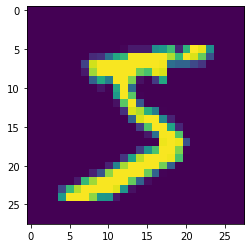

In [8]:
import tensorflow as tf
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data(path="mnist.npz")

plt.imshow(x_train[0])

# Utility functions

It will be helpful to recall the following definitions:

$\sigma(x) = \frac{1}{1 + e^{-x}}$

$\nabla \sigma(x) = \sigma(x)(1 - \sigma(x))$

$\text{softmax}(z)|_i = \frac{e^{z_i}}{\sum e^{z_i}}$

$CE(y,\hat{y}) = - \sum y_i \log \hat{y}_i$

In [9]:
import numpy as np

def sigmoid(x):
  x = np.clip(x, -500, 500)
  return 1 / (1 + np.exp(-x))

def dsigmoid(x):
  return sigmoid(x) * (1 - sigmoid(x))

def softmax(x):
  b = x.max()
  y = np.exp(x - b)
  return y / y.sum()

def cross_entropy_loss(y, yHat):
  return -np.sum(y * np.log(yHat))

def integer_to_one_hot(x, numclasses):
  result = np.zeros(numclasses)
  result[x] = 1
  return result

# Initialize architecture, weights, and biases

In [10]:
import math

weights = [
  np.random.normal(0, 1/math.sqrt(784), (784, 100)),
  np.random.normal(0, 1/math.sqrt(100), (100, 10))
]
biases = [np.zeros((1,100)), np.zeros((1,10))]


Let's just check to see that our network works by setting up a forward pass function. (This will also help evaluate test error later on)

In [11]:
def feed_forward_sample(sample, y):
  a = np.reshape(sample,(1,28*28))

  # Forward pass
  u1 = np.dot(a,weights[0]) + biases[0]
  z1 = sigmoid(u1)
  u2 = np.dot(z1,weights[1]) + biases[1]
  yhat = softmax(u2)

  # Calculate loss
  pred_class = np.argmax(yhat)
  one_hot_guess = integer_to_one_hot(pred_class,10)
  yvector = integer_to_one_hot(y,10)
  loss = cross_entropy_loss(yvector,yhat)
  
  return loss, one_hot_guess

def feed_forward_dataset(x, y):
  losses = np.empty(x.shape[0])
  one_hot_guesses = np.empty((x.shape[0], 10))

  for i in range(x.shape[0]):
    sample = np.reshape(x[i],(1,28*28))
    losses[i], one_hot_guesses[i] = feed_forward_sample(sample, y[i])

  y_one_hot = np.zeros((y.size, 10))
  y_one_hot[np.arange(y.size), y] = 1

  total_correct_guesses = np.sum(y_one_hot * one_hot_guesses)
  accuracy = format((total_correct_guesses / y.shape[0]) * 100, ".2f")
  print("Accuracy:", accuracy, "%)")

# Backprop

We go back up the computation graph, starting with differentiating the loss function with respect to the last-layer activations, and successively go backwards using the chain rule. Recall that the computation graph looks like:

$x \rightarrow u_1 \rightarrow z_1 \rightarrow u_2 \rightarrow \hat{y} \rightarrow L$

Some equations to consider:

$\partial_{u_2} L = \hat{y} - y$

$\partial_{w_2} L = \partial_{u_2} L \cdot \partial_{w_2} u_2 = (\hat{y} - y) z_1^T$

$\partial_{b_2} L = \partial_{u_2} L \cdot \partial_{b_2} u_2 = \hat{y} - y$

$\partial_{z_1} L = \partial_{u_2} L \cdot \partial_{z_1} u_2 = (\hat{y} - y) \cdot W_1$

$\partial_{u_1} L = \partial_{z_1} L \cdot \partial_{u_1} z_1 = (\hat{y} - y) \cdot W_1 \cdot \sigma'(u_1)$



In [12]:
def train_one_sample(sample, y, learning_rate=0.003):
  a = np.reshape(sample,(1,28*28))

  # intermediate variables
  weight_gradients = []
  bias_gradients = []

  # Forward pass
  u1 = np.dot(a,weights[0]) + biases[0]
  z1 = sigmoid(u1)
  u2 = np.dot(z1,weights[1]) + biases[1]
  yhat = softmax(u2)

  # Calculate loss
  pred_class = np.argmax(yhat)
  one_hot_guess = integer_to_one_hot(pred_class,10)
  yvector = integer_to_one_hot(y,10)
  loss = cross_entropy_loss(yvector,yhat)

  # Backward pass
  du2 = yhat - yvector
  dw2 = z1.T.dot(du2)
  db2 = du2
  
  dz1 = du2.dot(weights[1].T)
  du1 = np.multiply(dz1,dsigmoid(u1))
  dw1 = a.T.dot(du1)
  db1 = du1

  weight_gradients.append(dw1)
  weight_gradients.append(dw2)
  bias_gradients.append(db1)
  bias_gradients.append(db2)

  # update weights
  num_layers = 2
  for i in range(num_layers):
    weights[i] = weights[i] - learning_rate * weight_gradients[i]
    biases[i] = biases[i] - learning_rate * bias_gradients[i]
  
  return loss


# Testing

Great! Let's see how well we do. We can run the backward pass sample-by-sample, collect (all) gradients, and use them to update our weights/biases. Normally we would do this on the GPU; using plain numpy and CPU will take some time so we only train for 3 epochs.

After each epoch, we measure and report the test accuracy. We see that within a couple of epochs we reach close to 90\% accuracy, which is about the best we can hope to do with a one-hidden-layer network.

In [13]:
def train_one_epoch(learning_rate=0.001):
  print("Training for one epoch over the training dataset...")
  for i in range(x_train.shape[0]):
    train_one_sample(x_train[i], y_train[i], learning_rate)
  print("Finished training.\n")

# Train and check accuracy before & after each epoch

def test_and_train():
  train_one_epoch()
  feed_forward_dataset(x_test, y_test)

for i in range(3): # Adjust number of epochs here
  test_and_train()

Training for one epoch over the training dataset...
Finished training.

Accuracy: 87.45 %)
Training for one epoch over the training dataset...
Finished training.

Accuracy: 87.09 %)
Training for one epoch over the training dataset...
Finished training.

Accuracy: 87.20 %)


Great! Feel free to play around with architectures, learning rates, etc to figure out if you can get better performance. (Also, the datasets are unnormalized; it may help to pre-process all data points and normalize to [0,1].